In [31]:
import tensorflow as tf
import numpy as np
import glob
import os
from PIL import Image # Image後面會用到 #圖片轉換成二進位
import matplotlib.pyplot as plt

In [25]:
cwd = 'C:/Users/Java/Desktop/Project/Project_Image/'
classes = {'渡月橋','清水寺','龍安寺','金閣寺','平等院鳳凰堂','三十三間堂','千本鳥居','京都火車站','二條城'}
writer= tf.python_io.TFRecordWriter("kyoto_train.tfrecords") #要生成的文件

In [26]:
def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

for index, name in enumerate(classes):
    class_path = cwd + name + '//'
    for img_name in os.listdir(class_path):
        img_path = class_path + img_name    #每个图片的地址

        img = Image.open(img_path)
        img = img.resize((208, 208))
        img_raw = img.tobytes()  #将图片转化为二进制格式
        example = tf.train.Example(features = tf.train.Features(feature = {
                                                                           "label": _int64_feature(index),
                                                                           "img_raw": _bytes_feature(img_raw),                                                                          
                                                                           }))
        writer.write(example.SerializeToString())  #序列化为字符串
writer.close()

In [28]:
def read_and_decode(filename, batch_size): # read train.tfrecords
    filename_queue = tf.train.string_input_producer([filename],shuffle=False)# create a queue

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)#return file_name and file
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'label': tf.FixedLenFeature([], tf.int64),
                                           'img_raw' : tf.FixedLenFeature([], tf.string),
                                       })#return image and label

    img = tf.decode_raw(features['img_raw'], tf.uint8)
    img = tf.reshape(img, [208, 208, 3])  #reshape image to 208*208*3
    label = tf.cast(features['label'], tf.int32) #throw label tensor

    img_batch, label_batch = tf.train.shuffle_batch([img, label],
                                                    batch_size= 4,
                                                    num_threads=64,
                                                    capacity=2000,
                                                    min_after_dequeue=1500,
                                                    )
    return img_batch, tf.reshape(label_batch,[batch_size])

label: 0


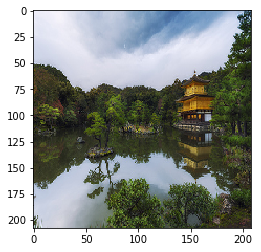

label: 0


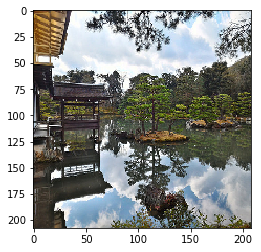

label: 0


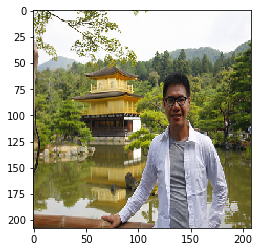

label: 0


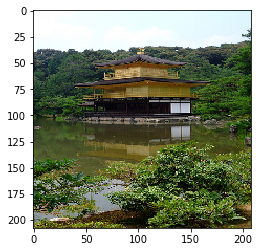

In [32]:
tfrecords_file = 'C:/Users/Java/Desktop/Project/Machine_Learning/kyoto_train.tfrecords'
BATCH_SIZE = 4
image_batch, label_batch = read_and_decode(tfrecords_file,BATCH_SIZE)

with tf.Session()  as sess:

    i = 0
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    try:
        while not coord.should_stop() and i<1:
            # just plot one batch size
            image, label = sess.run([image_batch, label_batch])
            for j in np.arange(4):
                print('label: %d' % label[j])
                plt.imshow(image[j,:,:,:])
                plt.show()
            i+=1
    except tf.errors.OutOfRangeError:
        print('done!')
    finally:
        coord.request_stop()
    coord.join(threads)